In [0]:
from __future__ import absolute_import, division, print_function

In [2]:
!pip install tensorflow-gpu==2.0.0-alpha0
import tensorflow as tf

In [3]:
# To generate GIFs
!pip install imageio

In [0]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
from pathlib import Path

from IPython import display

In [121]:
# en Colab usar esto 
!wget https://gitlab.com/i3a/clases/raw/master/utils.py -O utils.py
!pip install lap

from utils import mosaic

--2019-05-21 19:03:49--  https://gitlab.com/i3a/clases/raw/master/utils.py
Resolving gitlab.com (gitlab.com)... 35.231.145.151
Connecting to gitlab.com (gitlab.com)|35.231.145.151|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2800 (2.7K) [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]   2.73K  --.-KB/s    in 0s      

2019-05-21 19:03:49 (416 MB/s) - ‘utils.py’ saved [2800/2800]



### Preparo el dataset de pokemons

In [5]:
#usar en colab
!mkdir -p datasets
!wget -q https://gitlab.com/i3a/datasets/raw/master/datasets/pokemon-images.zip -O datasets/pokemon-images.zip
!unzip -o datasets/pokemon-images.zip -d datasets/

Archive:  datasets/pokemon-images.zip
   creating: datasets/pokemon-images/
  inflating: datasets/pokemon-images/1.png  
  inflating: datasets/pokemon-images/10.png  
  inflating: datasets/pokemon-images/100.png  
  inflating: datasets/pokemon-images/101.png  
  inflating: datasets/pokemon-images/102.png  
  inflating: datasets/pokemon-images/103.png  
  inflating: datasets/pokemon-images/104.png  
  inflating: datasets/pokemon-images/105.png  
  inflating: datasets/pokemon-images/106.png  
  inflating: datasets/pokemon-images/107.png  
  inflating: datasets/pokemon-images/108.png  
  inflating: datasets/pokemon-images/109.png  
  inflating: datasets/pokemon-images/11.png  
  inflating: datasets/pokemon-images/110.png  
  inflating: datasets/pokemon-images/111.png  
  inflating: datasets/pokemon-images/112.png  
  inflating: datasets/pokemon-images/113.png  
  inflating: datasets/pokemon-images/114.png  
  inflating: datasets/pokemon-images/115-mega.png  
  inflating: datasets/pokemon-

Vamos a tener que resizear las imágenes además de cargarlas a memoria

In [0]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256
CHANNELS = 3
SIZE = 128 #tamaño de la imagen

In [228]:
targetSize = SIZE,SIZE
fileList = glob.glob("datasets/pokemon-images/*.png")

imgs = []
img_names = []
for i, f in enumerate(fileList):
    img_names.append(Path(f).stem)
    img = PIL.Image.open(f)
    img.thumbnail( targetSize )
    img = np.array(img, dtype="float32")[:,:,0:CHANNELS]
    imgs.append(img)
    
imgs = np.array(imgs)
imgs.shape

(819, 128, 128, 3)

Hay que hacer un poco de reshape del dataset antes de mandarlo

(-0.5, 2559.5, 1279.5, -0.5)

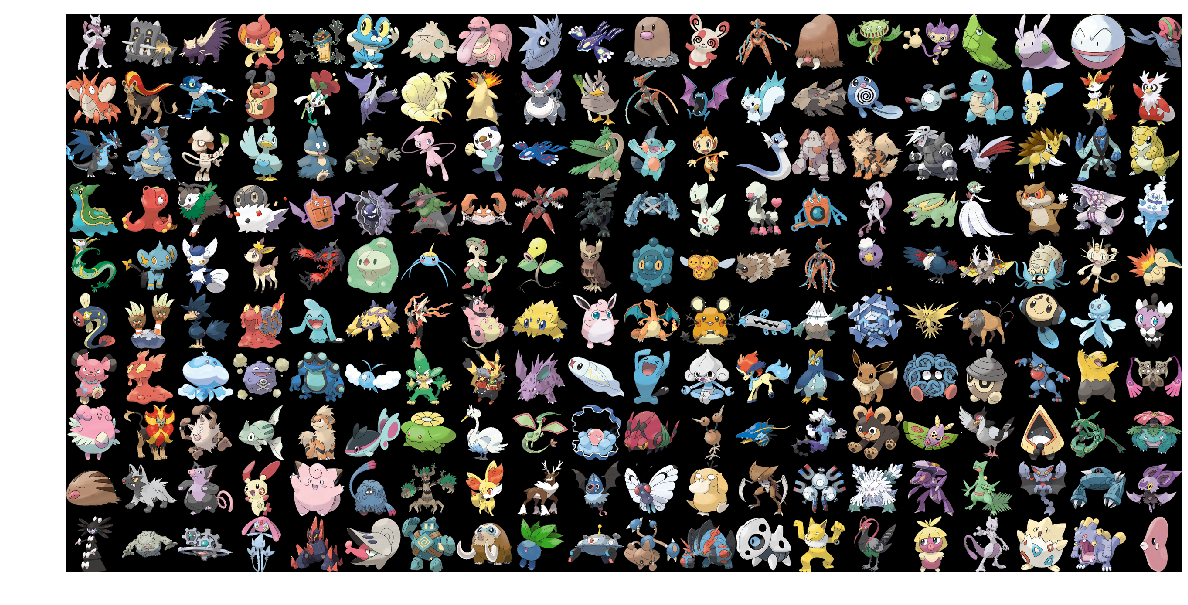

In [232]:
# imgs[0:10].squeeze().shape
plt.figure(figsize=(20,20))
plt.imshow( mosaic(imgs[0:200]/255, 20) )
plt.axis("off")

In [233]:
imgs = imgs[:,:,:,0:3]
imgs = (imgs - 127.5) / 127.5
print("Min: {}, Max: {}".format(np.min(imgs),np.max(imgs)))
print(imgs.shape)

Min: -1.0, Max: 1.0
(819, 128, 128, 3)


In [0]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(imgs).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)


## Create the models

Both the generator and discriminator are defined using the [Keras Sequential API](https://www.tensorflow.org/guide/keras#sequential_model).

### The Generator

The generator uses `tf.keras.layers.Conv2DTranspose` (upsampling) layers to produce an image from a seed (random noise). Start with a `Dense` layer that takes this seed as input, then upsample several times until you reach the desired image size of 28x28x1. Notice the `tf.keras.layers.LeakyReLU` activation for each layer, except the output layer which uses tanh.

In [0]:
def make_generator_model():
    neurons = int(SIZE / 4)
    
    model = tf.keras.Sequential()
    model.add(layers.Dense(neurons*neurons*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
      
    model.add(layers.Reshape((neurons, neurons, 256)))
    assert model.output_shape == (None, neurons, neurons, 256) # Note: None is the batch size
    
#     model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.Conv2D(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, neurons, neurons, 128)  
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

#     model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
#   assert model.output_shape == (None, neurons*2, neurons*2, 64)  
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.UpSampling2D((4,4)))
    assert model.output_shape == (None, neurons*2, neurons*2, 64)    
    
    model.add(layers.Conv2D(CHANNELS, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    model.add(layers.UpSampling2D((4,4)))
    assert model.output_shape == (None, SIZE, SIZE, CHANNELS)
  
    return model

Use the (as yet untrained) generator to create an image.

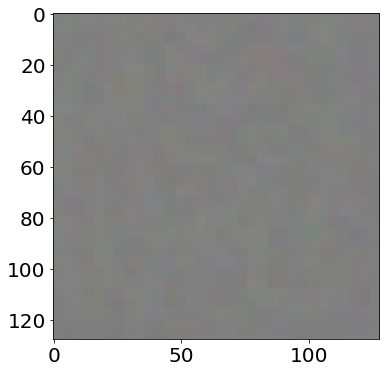

In [339]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

generated_image[0].shape

plt.imshow( np.array(generated_image[0]) * 0.5 + 0.5, cmap="gray" )

### The Discriminator

The discriminator is a CNN-based image classifier.

In [0]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', 
                                     input_shape=(SIZE, SIZE, CHANNELS)))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
      
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
       
    model.add(layers.Flatten())
    model.add(layers.Dense(1))
     
    return model

Use the (as yet untrained) discriminator to classify the generated images as real or fake. The model will be trained to output positive values for real images, and negative values for fake images.

In [341]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.00393088]], shape=(1, 1), dtype=float32)


## Define the loss and optimizers

Define loss functions and optimizers for both models.


In [0]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Discriminator loss

This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the disciminator's predictions on real images to an array of 1s, and the disciminator's predictions on fake (generated) images to an array of 0s.

In [0]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Generator loss
The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, we will compare the disciminators decisions on the generated images to an array of 1s.

In [0]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

The discriminator and the generator optimizers are different since we will train two networks separately.

In [0]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### Save checkpoints
This notebook also demonstrates how to save and restore models, which can be helpful in case a long running training task is interrupted.

In [0]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Define the training loop



In [0]:
EPOCHS = 600
noise_dim = 100
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [0]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)
#       display("G_loss: {} D_loss: {}".format(gen_loss,disc_loss))

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [0]:
def train(dataset, epochs):  
  for epoch in range(epochs):
    start = time.time()
    
    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)
    
    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)
    
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
    
  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

**Generate and save images**



In [0]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False. 
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(20,20))
  
  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
#       plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.imshow(predictions[i] * 0.5 + 0.5)
      plt.axis('off')
        
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

## Train the model
Call the `train()` method defined above to train the generator and discriminator simultaneously. Note, training GANs can be tricky. It's important that the generator and discriminator do not overpower each other (e.g., that they train at a similar rate).

At the beginning of the training, the generated images look like random noise. As training progresses, the generated digits will look increasingly real. After about 50 epochs, they resemble MNIST digits. This may take about one minute / epoch with the default settings on Colab.

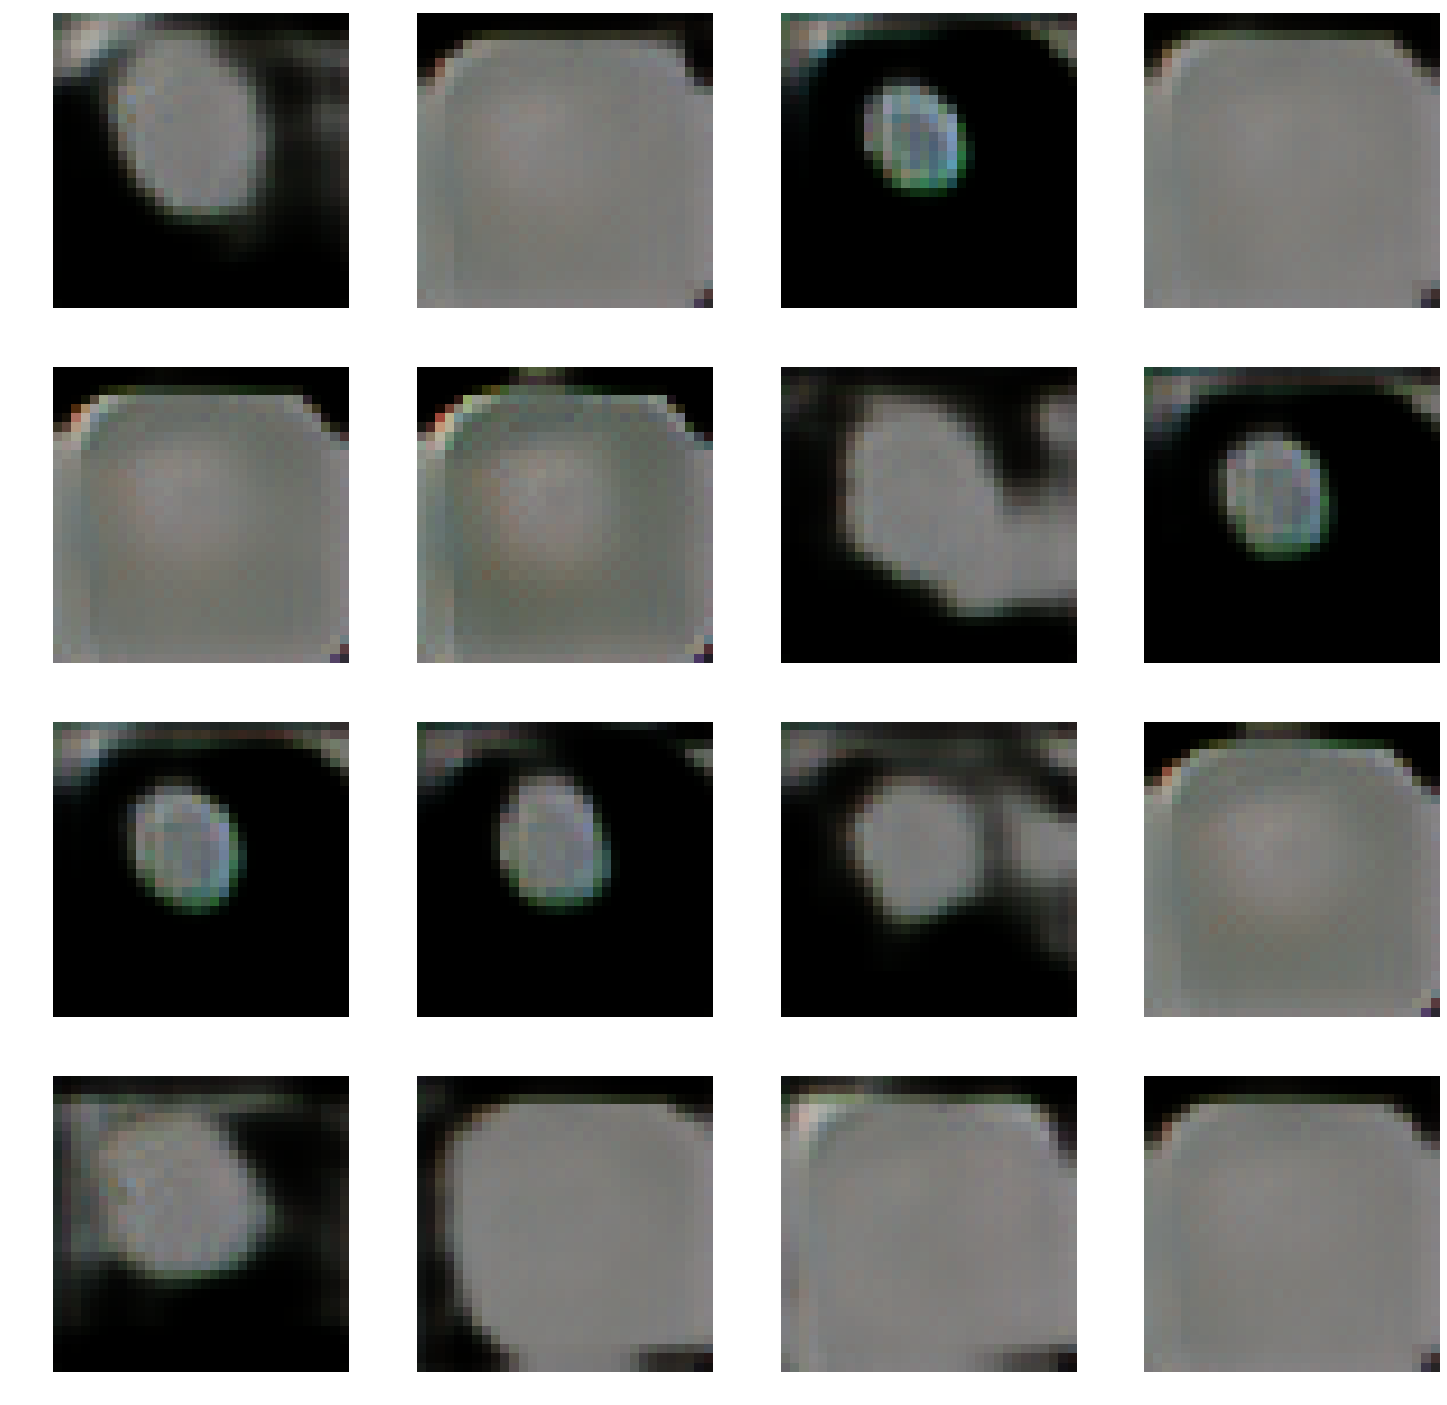

CPU times: user 32min 3s, sys: 4min 42s, total: 36min 45s
Wall time: 56min 37s


In [354]:
%%time
train(train_dataset, EPOCHS)

Restore the latest checkpoint.

In [0]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Create a GIF


In [0]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

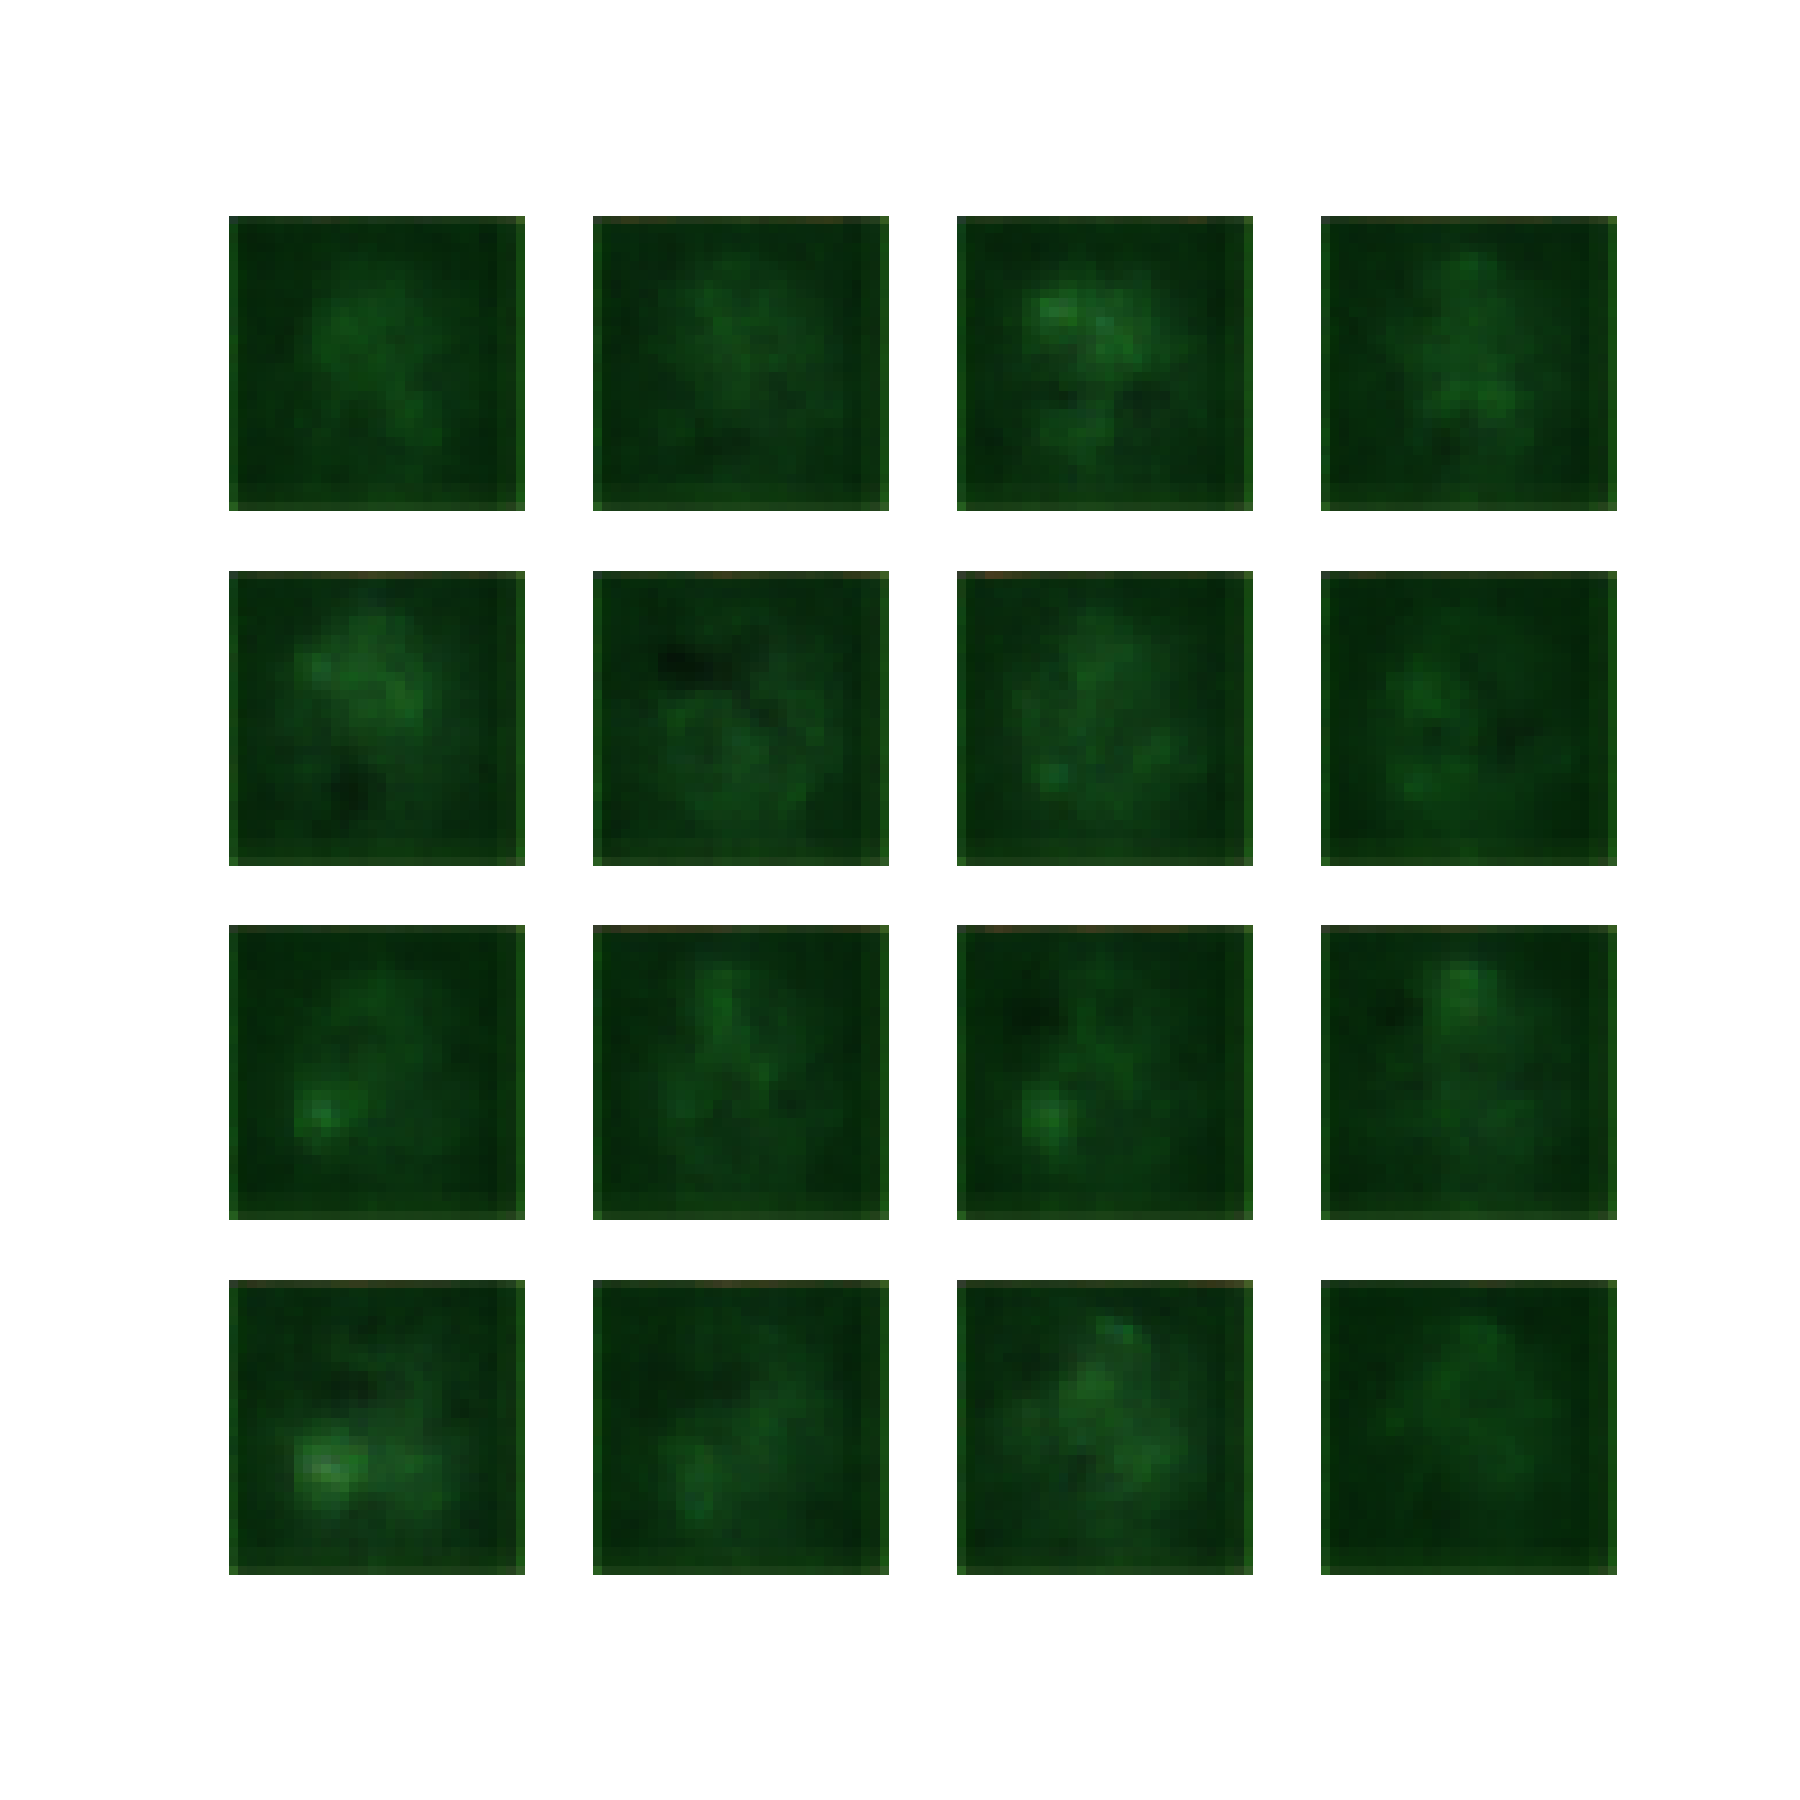

In [355]:
display_image(1)

Use `imageio` to create an animated gif using the images saved during training.

In [0]:
with imageio.get_writer('dcgan.3.gif', mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)
    
# A hack to display the GIF inside this notebook
os.rename('dcgan.3.gif', 'dcgan.3.gif.png')

Display the animated gif with all the mages generated during the training of GANs.

In [0]:
display.Image(filename="dcgan.3.gif.png")

(-0.5, 1279.5, 1407.5, -0.5)

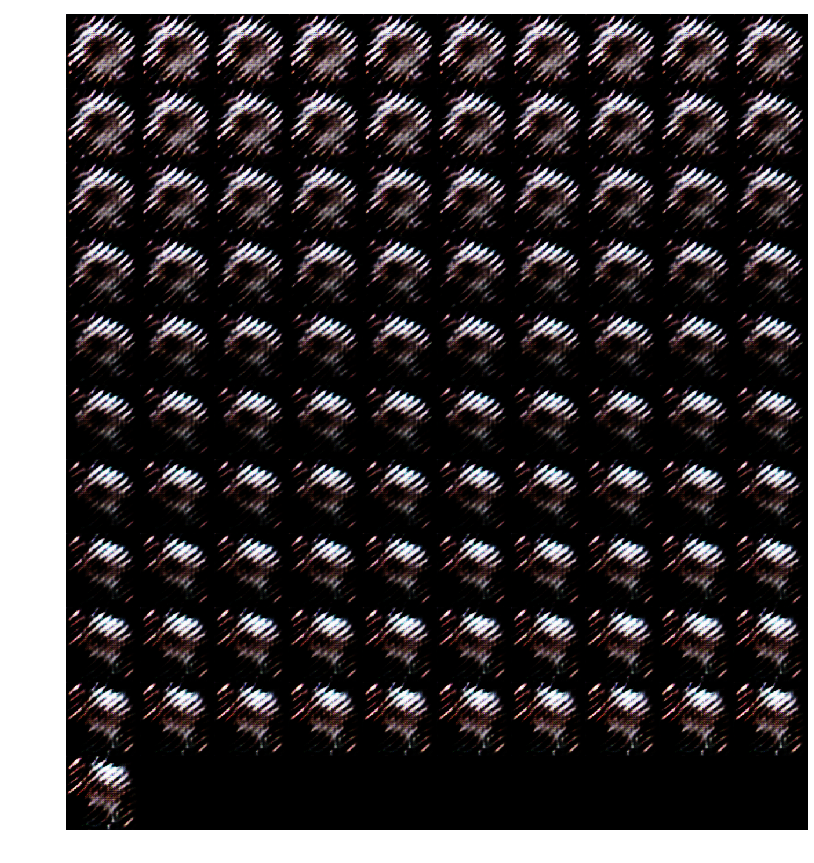

In [294]:
from scipy.interpolate import interp1d

cantInterpolation = 100

realNoise = np.random.normal(0, 1, (2, 100))

x = np.array([0,1])
y = realNoise
f = interp1d( x , y, axis = 0  )

noise = f( np.linspace(0,1,cantInterpolation+1, endpoint = False) )
gen_imgs = generator(noise, training=False)
gen_imgs = 0.5 * gen_imgs + 0.5

plt.figure(figsize=(15,15))
plt.imshow( mosaic( gen_imgs, 10 ) )
plt.axis("off")

(-0.5, 1279.5, 5247.5, -0.5)

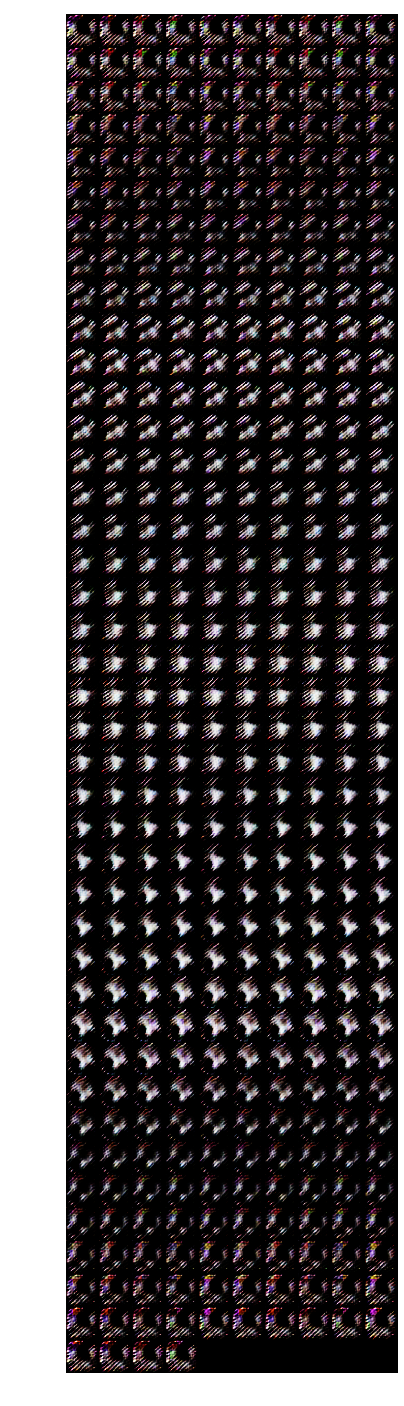

In [315]:
from scipy.interpolate import interp1d

cantInterpolation = 100
cantRandom = 5

realNoise = np.random.normal(0, 1, (cantRandom-1, 100))
realNoise = np.vstack( ( realNoise, realNoise[0] ) )

allImgs = []
for i in range(cantRandom-1):
    x = np.array([0,1])
    y = realNoise[i:i+2]
    f = interp1d( x , y, axis = 0  )

    noise = f( np.linspace(0,1,cantInterpolation+1, endpoint = False) )
    gen_imgs = generator(noise, training=False)
    gen_imgs = 0.5 * gen_imgs + 0.5
    
    allImgs.append(np.array(gen_imgs))

npAllImages = allImgs[0]
for i in range(1, len(allImgs)):
  npAllImages = np.vstack( (npAllImages, allImgs[i]) )

plt.figure(figsize=(25,25))
plt.imshow( mosaic( npAllImages, 10 ) )
plt.axis("off")

In [0]:
with imageio.get_writer('interpol.gif', mode='I') as writer:
  for i in range(0,npAllImages.shape[0]):
    writer.append_data(npAllImages[i])
    
# A hack to display the GIF inside this notebook
os.rename('interpol.gif', 'interpol.gif.png')

In [319]:
display.Image(filename="interpol.gif.png")

Output hidden; open in https://colab.research.google.com to view.